<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/neural_ipinn_21_02_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 827.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data
time_points = np.array([1.0, 2.0, 4.0])  # Time points (1d, 2d, 4d)
gene_expressions = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32)
gene_expressions_tensor = torch.tensor(gene_expressions, dtype=torch.float32)

In [9]:
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time, Output: hidden state
            nn.Tanh(),
            nn.Linear(16, n_genes)  # Output: derivatives for all genes
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        # y: (batch_size, n_genes)
        # t: scalar
        t_tensor = torch.ones_like(y[:, 0]).unsqueeze(-1) * t  # Broadcast t to match y's shape
        return self.net(t_tensor)  # Compute derivatives

class NeuralODEModel(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, t, y0):
        return odeint(self.odefunc, y0, t, method='dopri5')  # Solve ODE

In [10]:
def inverse_pinn_loss(model, time_points, observed_data):
    # Initial condition (gene expressions at t=1d)
    y0 = observed_data[:, 0].unsqueeze(0)  # Shape: (1, n_genes)

    # Solve ODE
    preds = model(time_points, y0).squeeze(0)  # Shape: (n_time_points, n_genes)

    # Compute data loss (MSE between predictions and observed data)
    data_loss = torch.mean((preds - observed_data.T) ** 2)

    return data_loss

In [11]:
# Initialize model, loss function, and optimizer
n_genes = gene_expressions.shape[0]  # Number of genes
odefunc = ODEFunc(n_genes)
model = NeuralODEModel(odefunc)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Compute loss
    loss = inverse_pinn_loss(model, time_points_tensor, gene_expressions_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 3.9531736373901367
Epoch 100, Loss: 1.7833342552185059
Epoch 200, Loss: 1.764594554901123
Epoch 300, Loss: 1.763683557510376
Epoch 400, Loss: 1.7636733055114746
Epoch 500, Loss: 1.7636733055114746
Epoch 600, Loss: 1.7636733055114746
Epoch 700, Loss: 1.7636733055114746
Epoch 800, Loss: 1.7636733055114746
Epoch 900, Loss: 1.7636733055114746


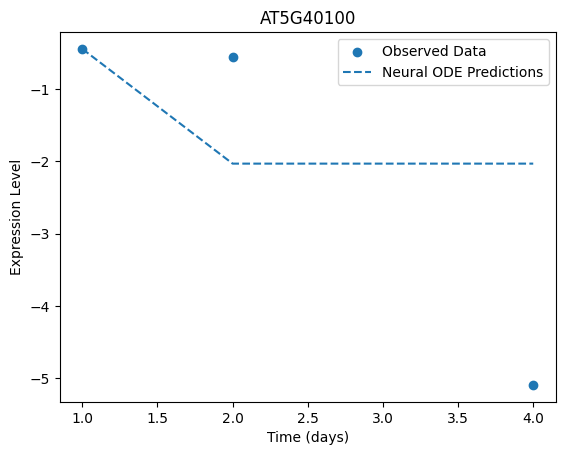

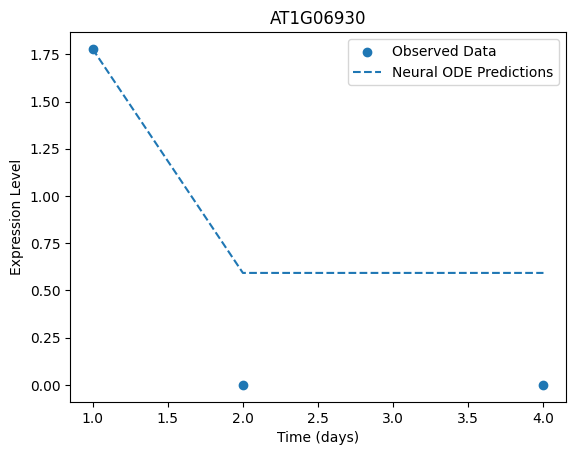

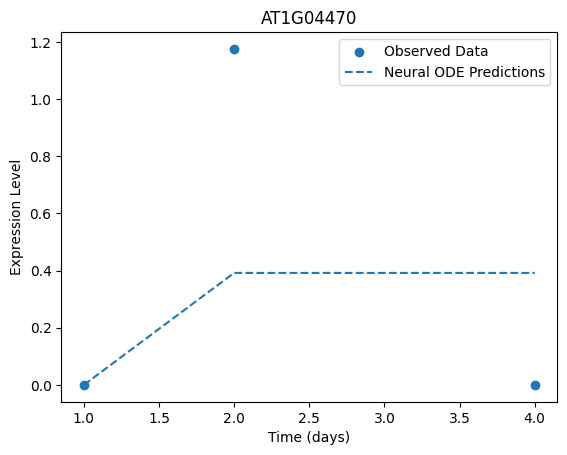

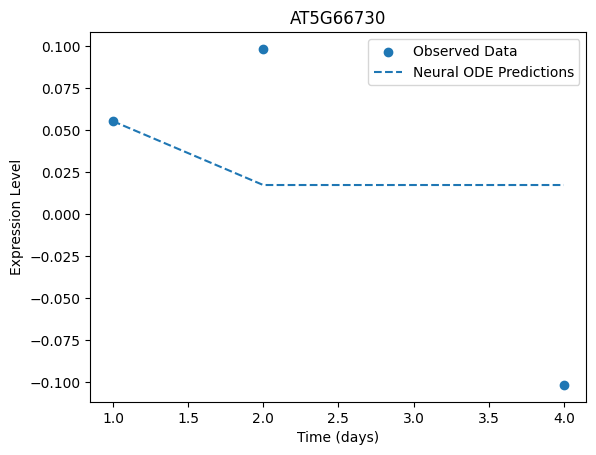

In [16]:
# Generate predictions
with torch.no_grad():
    y0 = gene_expressions_tensor[:, 0].unsqueeze(0)  # Initial condition
    preds = model(time_points_tensor, y0).squeeze(0).numpy()  # Shape: (n_time_points, n_genes)
    preds = preds.reshape(preds.shape[0],-1) # Reshape preds

# Plot the results
for i, gene_id in enumerate(df["Gene"]):
    plt.figure()
    plt.scatter(time_points, gene_expressions[i], label="Observed Data")
    plt.plot(time_points, preds[:, i], label="Neural ODE Predictions", linestyle="--")  # Access predictions for the current gene
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
    plt.show()

In [13]:
# Print learned parameters
print("Learned ODE Parameters:")
for name, param in odefunc.named_parameters():
    if param.requires_grad:
        print(f"{name}:")
        print(param.data)

Learned ODE Parameters:
net.0.weight:
tensor([[-0.7741],
        [ 0.0592],
        [-0.3098],
        [-0.4894],
        [ 1.3706],
        [-0.4428],
        [ 1.1434],
        [-0.4368],
        [ 0.3186],
        [ 1.0353],
        [-0.1299],
        [ 0.0145],
        [-0.3327],
        [ 1.3237],
        [-0.6192],
        [ 0.7289]])
net.0.bias:
tensor([-1.0403, -0.1916,  0.4425,  0.9756,  0.3704,  0.5464,  0.4825,  0.9584,
         0.1357,  0.3896,  0.5494,  0.7921,  0.6227,  0.4274,  1.1876,  0.6062])
net.2.weight:
tensor([[ 0.0027,  0.1189, -0.5124, -0.6423, -0.0655, -0.1531, -0.3472, -0.5041,
         -0.2023, -0.1837, -0.3327, -0.2523, -0.7473, -0.2847, -0.2726,  0.0112],
        [ 0.1376,  0.1809, -0.0836, -0.3864, -0.1276, -0.1627, -0.2224, -0.6012,
          0.1096, -0.2185, -0.0186,  0.0603, -0.4745, -0.3060, -0.2574,  0.0046],
        [-0.1005, -0.0407, -0.0267,  0.2770,  0.0640, -0.1700, -0.0642,  0.3193,
         -0.1217,  0.0950, -0.0008, -0.1676,  0.0223,  0.1882, 

In [17]:
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_genes + 1, 16),  # Input: gene expressions (n_genes) + time (1)
            nn.Tanh(),
            nn.Linear(16, n_genes)  # Output: derivatives for all genes
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        # Concatenate time `t` to the state `y`
        t_tensor = torch.ones_like(y[:, 0]).unsqueeze(-1) * t  # Shape: (batch_size, 1)
        y_with_time = torch.cat([y, t_tensor], dim=1)  # Shape: (batch_size, n_genes + 1)
        return self.net(y_with_time)

In [26]:
# Extract parameters from the trained model
W1 = odefunc.net[0].weight.detach().numpy()  # Shape: (16, n_genes + 1)
b1 = odefunc.net[0].bias.detach().numpy()     # Shape: (16,)
W2 = odefunc.net[2].weight.detach().numpy()   # Shape: (n_genes, 16)
b2 = odefunc.net[2].bias.detach().numpy()     # Shape: (n_genes,)

# Print ODEs for each gene
print("Learned ODEs:")
for i, gene_id in enumerate(df["Gene"]):
    ode_equation = f"d{gene_id}/dt = "
    for j in range(16):
        # Terms from the first layer (W1[j, :] and b1[j])
        # Access the correct elements of W1 based on its shape
        linear_term = " + ".join([f"{W1[j, 0]:.4f}·y_{k+1}" for k in range(n_genes)]) + f" + {W1[j, 0]:.4f}·t + {b1[j]:.4f}"
        tanh_term = f"tanh({linear_term})"

        # Multiply by W2[i, j] and accumulate
        ode_equation += f"{W2[i, j]:.4f}·{tanh_term} + "

    # Add the bias term b2[i]
    ode_equation += f"{b2[i]:.4f}"
    print(ode_equation + "\n")

Learned ODEs:
dAT5G40100/dt = 0.0027·tanh(-0.7741·y_1 + -0.7741·y_2 + -0.7741·y_3 + -0.7741·y_4 + -0.7741·t + -1.0403) + 0.1189·tanh(0.0592·y_1 + 0.0592·y_2 + 0.0592·y_3 + 0.0592·y_4 + 0.0592·t + -0.1916) + -0.5124·tanh(-0.3098·y_1 + -0.3098·y_2 + -0.3098·y_3 + -0.3098·y_4 + -0.3098·t + 0.4425) + -0.6423·tanh(-0.4894·y_1 + -0.4894·y_2 + -0.4894·y_3 + -0.4894·y_4 + -0.4894·t + 0.9756) + -0.0655·tanh(1.3706·y_1 + 1.3706·y_2 + 1.3706·y_3 + 1.3706·y_4 + 1.3706·t + 0.3704) + -0.1531·tanh(-0.4428·y_1 + -0.4428·y_2 + -0.4428·y_3 + -0.4428·y_4 + -0.4428·t + 0.5464) + -0.3472·tanh(1.1434·y_1 + 1.1434·y_2 + 1.1434·y_3 + 1.1434·y_4 + 1.1434·t + 0.4825) + -0.5041·tanh(-0.4368·y_1 + -0.4368·y_2 + -0.4368·y_3 + -0.4368·y_4 + -0.4368·t + 0.9584) + -0.2023·tanh(0.3186·y_1 + 0.3186·y_2 + 0.3186·y_3 + 0.3186·y_4 + 0.3186·t + 0.1357) + -0.1837·tanh(1.0353·y_1 + 1.0353·y_2 + 1.0353·y_3 + 1.0353·y_4 + 1.0353·t + 0.3896) + -0.3327·tanh(-0.1299·y_1 + -0.1299·y_2 + -0.1299·y_3 + -0.1299·y_4 + -0.1299·t + 0.54

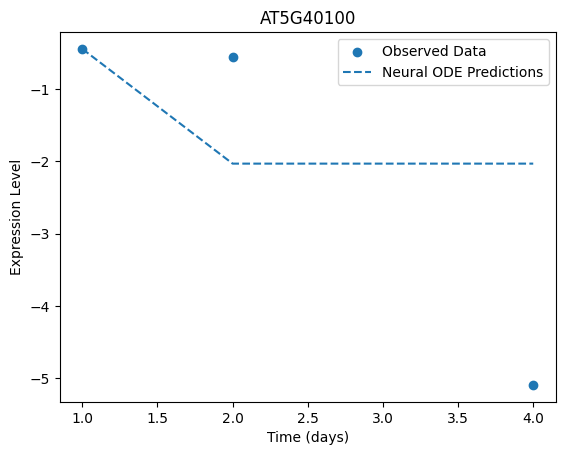

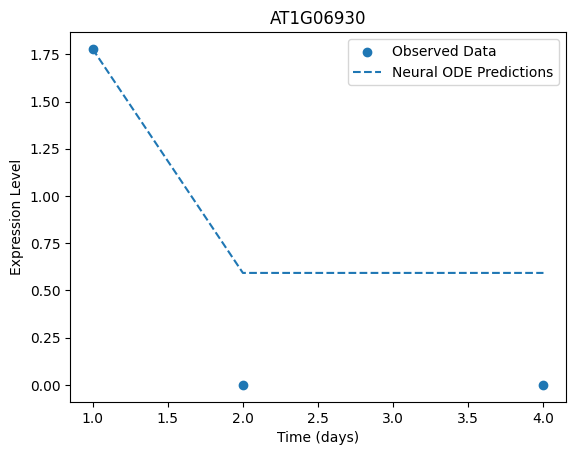

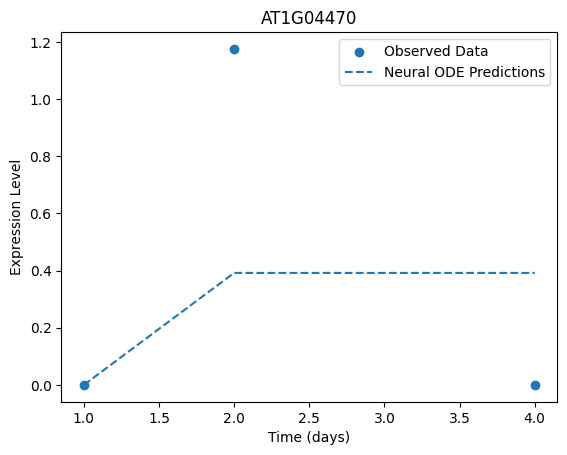

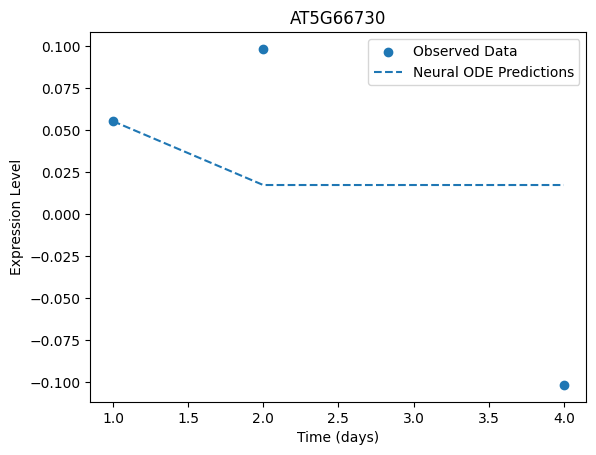

In [28]:
# Generate predictions
with torch.no_grad():
    y0 = gene_expressions_tensor[:, 0].unsqueeze(0)  # Initial condition
    preds = model(time_points_tensor, y0).squeeze(0).numpy()  # Shape: (n_time_points, n_genes)
    preds = preds.reshape(preds.shape[0],-1) # Reshape preds

# Plot the results
for i, gene_id in enumerate(df["Gene"]):
    plt.figure()
    plt.scatter(time_points, gene_expressions[i], label="Observed Data")
    plt.plot(time_points, preds[:, i], label="Neural ODE Predictions", linestyle="--")  # Access predictions for the current gene
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
    plt.show()

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data (row-wise)
time_points = np.array([1.0, 2.0, 4.0])  # Days 1, 2, 4
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors (each row is a separate time series)
time_points_tensor = torch.tensor(time_points, dtype=torch.float32)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (4, 3)

In [9]:
time_points_tensor

tensor([1., 2., 4.])

In [10]:
gene_data_tensor

tensor([[-0.4480, -0.5602, -5.0920],
        [ 1.7784,  0.0000,  0.0000],
        [ 0.0000,  1.1751,  0.0000],
        [ 0.0554,  0.0984, -0.1018]])

In [20]:
class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a simple network for a single gene's dynamics
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time (scalar), Output: hidden state
            nn.Tanh(),
            nn.Linear(16, 1)    # Output: derivative of the gene's expression
        )

    def forward(self, t, y):
        # y: (batch_size, 1) = current gene expression
        # t: scalar
        t_tensor = torch.ones_like(y) * t  # Shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)  # Compute derivative
        return dy_dt

# Initialize one ODE model per gene
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])

In [5]:
def inverse_pinn_loss(ode_models, time_points, gene_data):
    total_loss = 0.0
    for i in range(n_genes):
        # Extract data for the i-th gene
        y_true = gene_data[i].unsqueeze(-1)  # Shape: (3, 1)

        # Initial condition (expression at t=1d)
        y0 = y_true[0].unsqueeze(0)  # Shape: (1, 1)

        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # Shape: (3,)

        # Compute MSE loss for this gene
        loss = torch.mean((preds - y_true.squeeze()) ** 2)
        total_loss += loss

    return total_loss / n_genes  # Average loss across genes

In [6]:
optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 3.0723
Epoch 100, Loss: 0.0795
Epoch 200, Loss: 0.0030
Epoch 300, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


In [13]:
# gene_data

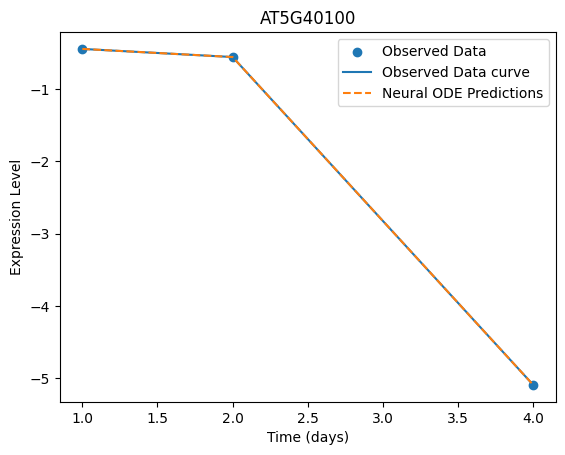

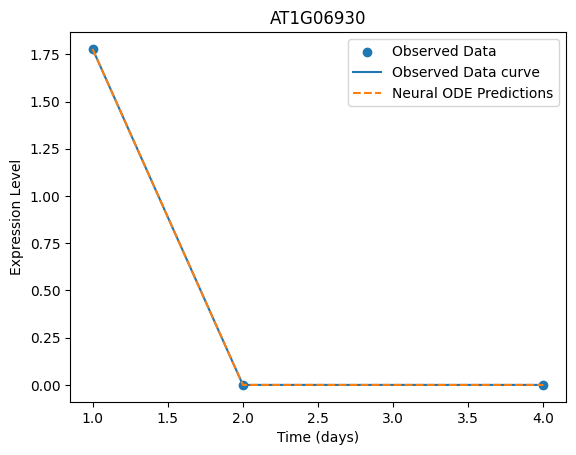

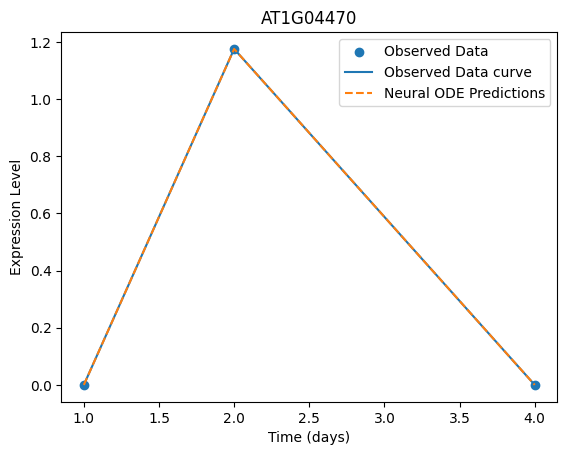

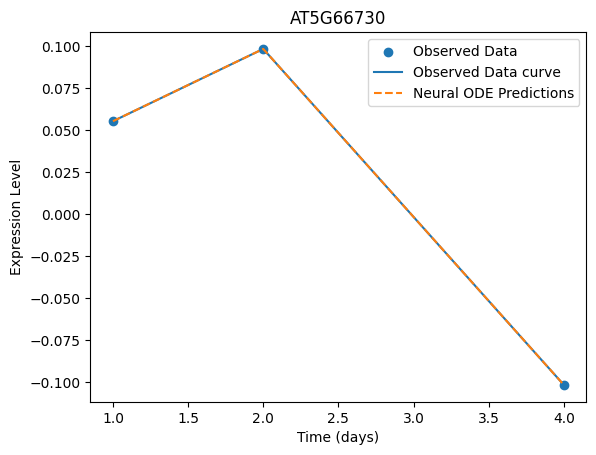

In [14]:
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Initial condition (t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)

        # Solve the ODE
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot
        plt.figure()
        plt.scatter(time_points, gene_data[i], label="Observed Data")
        plt.plot(time_points, gene_data[i], label="Observed Data curve")

        plt.plot(time_points, preds, label="Neural ODE Predictions", linestyle="--")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

In [8]:
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    W1 = model.net[0].weight.detach().numpy().flatten()  # Input layer weights
    b1 = model.net[0].bias.detach().numpy().flatten()    # Input layer bias
    W2 = model.net[2].weight.detach().numpy().flatten()  # Output layer weights
    b2 = model.net[2].bias.detach().numpy().flatten()    # Output layer bias

    # ODE equation: dy/dt = W2 * tanh(W1 * t + b1) + b2
    equation = f"d{gene_id}/dt = "
    equation += f"{W2[0]:.4f} * tanh("
    equation += " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print(equation + "\n")

dAT5G40100/dt = 0.2329 * tanh(-0.1934·t + 0.6486·t + 0.7562·t + 0.5088·t + 0.5543·t + -0.5536·t + 0.6112·t + 0.3471·t + -0.4783·t + -0.3677·t + -0.3619·t + -0.6237·t + -0.7028·t + 0.4172·t + 0.5348·t + -0.2564·t + -0.5644) + -0.1312

dAT1G06930/dt = -0.1602 * tanh(-0.2760·t + -0.6648·t + -0.8428·t + 0.2489·t + 0.3286·t + -0.4444·t + 1.2444·t + 0.4069·t + -0.2443·t + -0.4314·t + -0.2046·t + -0.9493·t + -0.3658·t + 0.8558·t + -1.4115·t + -0.6800·t + 0.1391) + 0.1365

dAT1G04470/dt = -0.6214 * tanh(0.5045·t + -1.1032·t + -0.6437·t + -0.3443·t + -0.3392·t + 0.5036·t + -0.2490·t + -0.7238·t + -0.1417·t + -0.3800·t + 0.2033·t + 0.6395·t + -0.8163·t + 1.2088·t + 0.4756·t + -0.4486·t + -1.0282) + 0.1083

dAT5G66730/dt = -0.0427 * tanh(-0.8022·t + -0.1732·t + -0.1970·t + -0.4797·t + -0.4162·t + -0.0448·t + -0.7275·t + 0.6577·t + -0.5564·t + -0.7377·t + 0.3261·t + 0.3654·t + -0.6741·t + -0.5012·t + 0.1959·t + -0.0974·t + 0.1975) + -0.2321



In [16]:
# Use the trained model to predict gene expressions at [1d, 2d, 4d]
with torch.no_grad():
    predictions = []
    for i in range(n_genes):
        # Initial condition (expression at t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        predictions.append(preds)

# Convert to numpy array
predictions = np.array(predictions)  # Shape: (4 genes, 3 time points)

# Calculate MSE for each gene
mse = np.mean((predictions - gene_data) ** 2, axis=1)
print("Mean Squared Error (MSE) for each gene:")
for i, gene_id in enumerate(df["Gene"]):
    print(f"{gene_id}: {mse[i]:.4e}")

Mean Squared Error (MSE) for each gene:
AT5G40100: 3.6629e-12
AT1G06930: 1.0545e-15
AT1G04470: 1.5724e-12
AT5G66730: 8.8732e-19


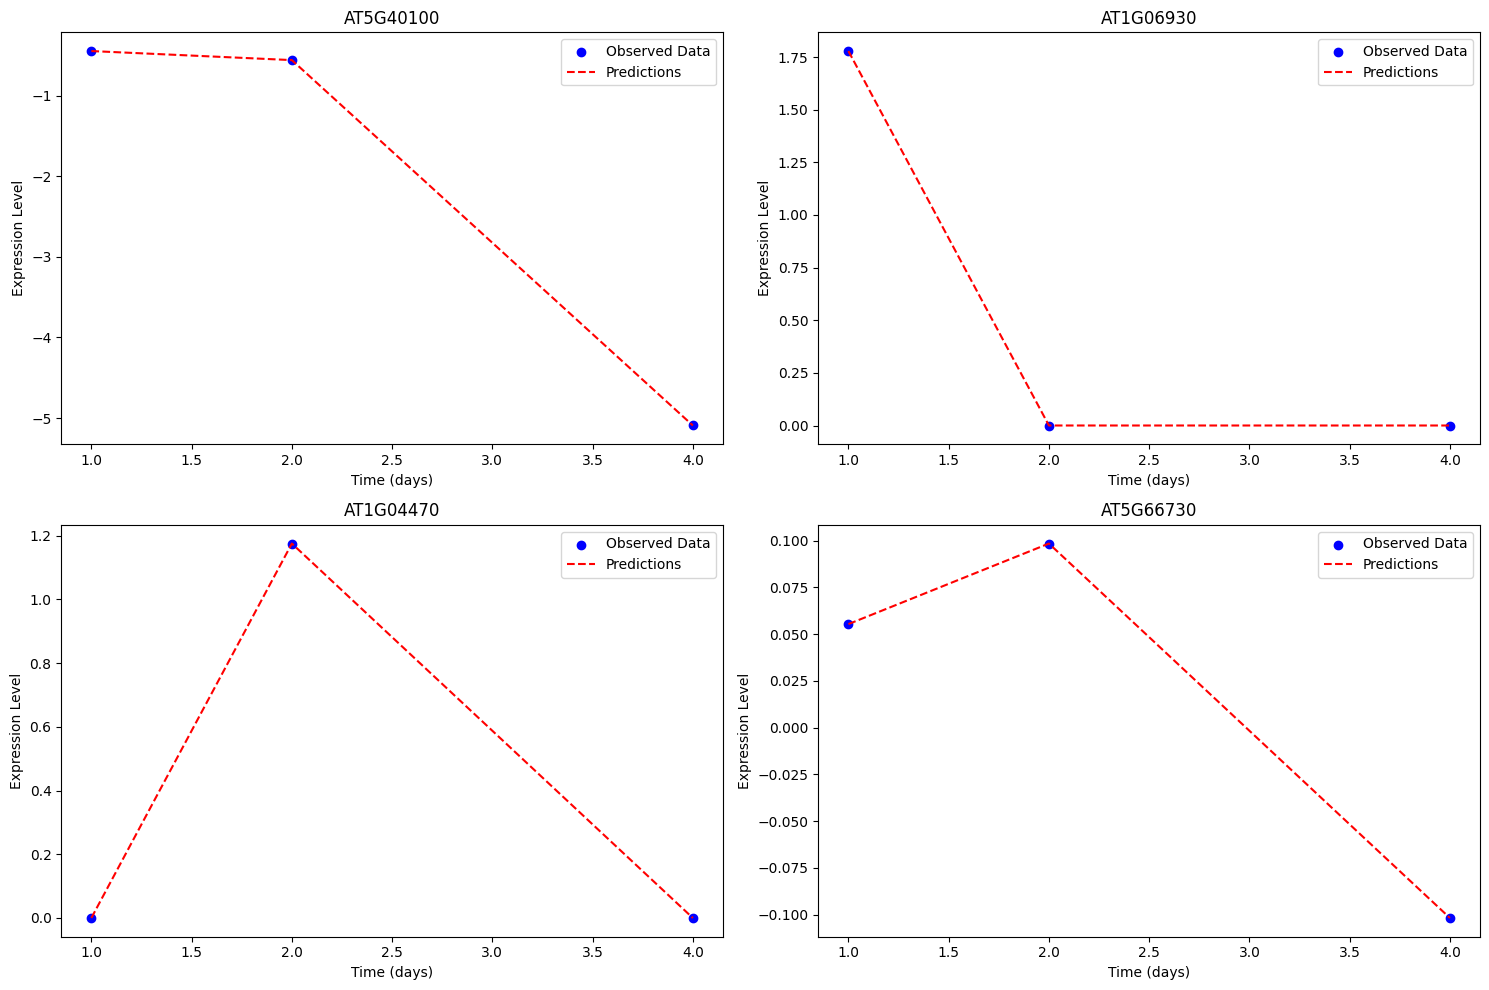

In [17]:
plt.figure(figsize=(15, 10))
for i, gene_id in enumerate(df["Gene"]):
    plt.subplot(2, 2, i+1)
    plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
    plt.plot(time_points, predictions[i], 'r--', label="Predictions")
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
plt.tight_layout()
plt.show()

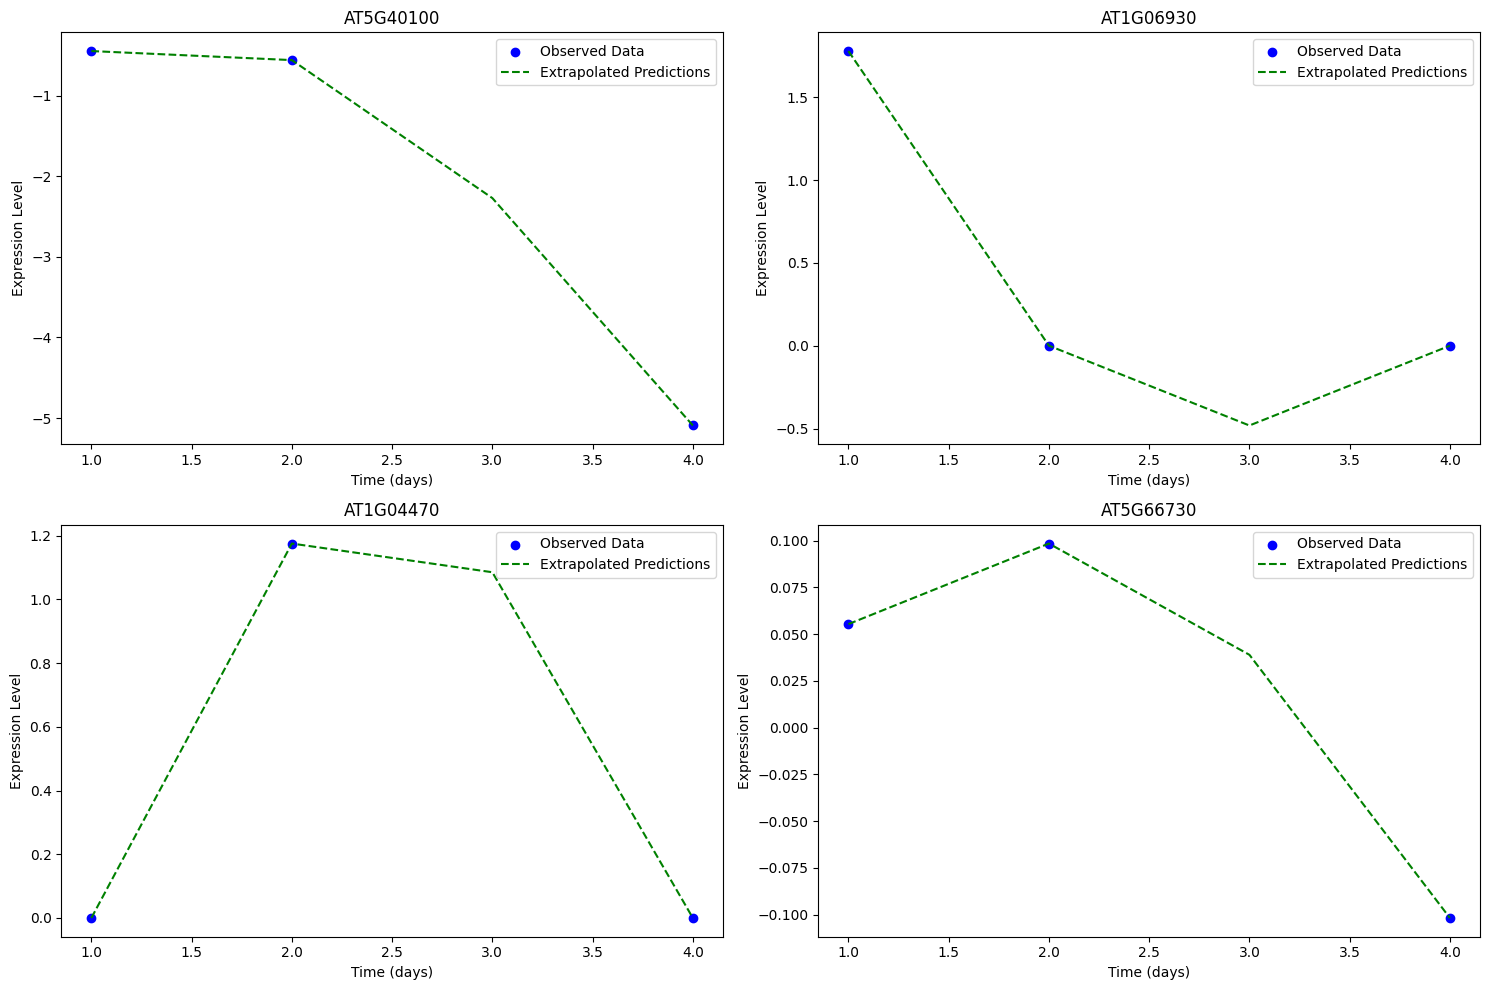

In [18]:
# Define new time points including t=3d
new_time_points = torch.tensor([1.0, 2.0, 3.0, 4.0], dtype=torch.float32)

# Generate predictions for new time points
with torch.no_grad():
    extrapolated_predictions = []
    for i in range(n_genes):
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        preds = odeint(ode_models[i], y0, new_time_points).squeeze().numpy()
        extrapolated_predictions.append(preds)

# Plot extrapolation results
plt.figure(figsize=(15, 10))
for i, gene_id in enumerate(df["Gene"]):
    plt.subplot(2, 2, i+1)
    plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
    plt.plot(new_time_points, extrapolated_predictions[i], 'g--', label="Extrapolated Predictions")
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [19]:
print("\nLearned ODE Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    W1 = model.net[0].weight.detach().numpy().flatten()
    b1 = model.net[0].bias.detach().numpy().flatten()
    W2 = model.net[2].weight.detach().numpy().flatten()
    b2 = model.net[2].bias.detach().numpy().flatten()

    equation = f"d{gene_id}/dt = "
    equation += f"{W2[0]:.4f} * tanh("
    equation += " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print(equation + "\n")


Learned ODE Equations:
dAT5G40100/dt = 0.2329 * tanh(-0.1934·t + 0.6486·t + 0.7562·t + 0.5088·t + 0.5543·t + -0.5536·t + 0.6112·t + 0.3471·t + -0.4783·t + -0.3677·t + -0.3619·t + -0.6237·t + -0.7028·t + 0.4172·t + 0.5348·t + -0.2564·t + -0.5644) + -0.1312

dAT1G06930/dt = -0.1602 * tanh(-0.2760·t + -0.6648·t + -0.8428·t + 0.2489·t + 0.3286·t + -0.4444·t + 1.2444·t + 0.4069·t + -0.2443·t + -0.4314·t + -0.2046·t + -0.9493·t + -0.3658·t + 0.8558·t + -1.4115·t + -0.6800·t + 0.1391) + 0.1365

dAT1G04470/dt = -0.6214 * tanh(0.5045·t + -1.1032·t + -0.6437·t + -0.3443·t + -0.3392·t + 0.5036·t + -0.2490·t + -0.7238·t + -0.1417·t + -0.3800·t + 0.2033·t + 0.6395·t + -0.8163·t + 1.2088·t + 0.4756·t + -0.4486·t + -1.0282) + 0.1083

dAT5G66730/dt = -0.0427 * tanh(-0.8022·t + -0.1732·t + -0.1970·t + -0.4797·t + -0.4162·t + -0.0448·t + -0.7275·t + 0.6577·t + -0.5564·t + -0.7377·t + 0.3261·t + 0.3654·t + -0.6741·t + -0.5012·t + 0.1959·t + -0.0974·t + 0.1975) + -0.2321



Epoch 0, Loss: 3.8583
Epoch 100, Loss: 0.2189
Epoch 200, Loss: 0.1329
Epoch 300, Loss: 0.0721


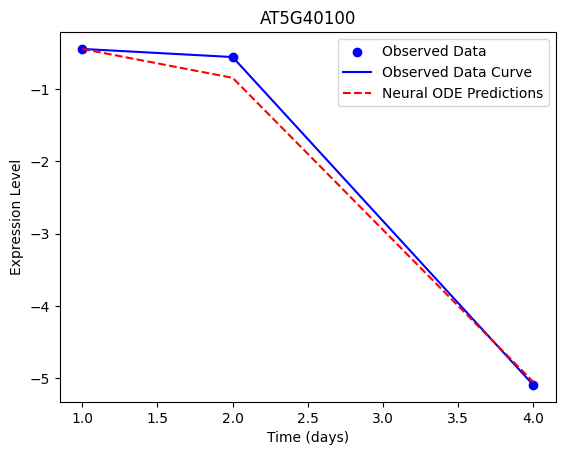

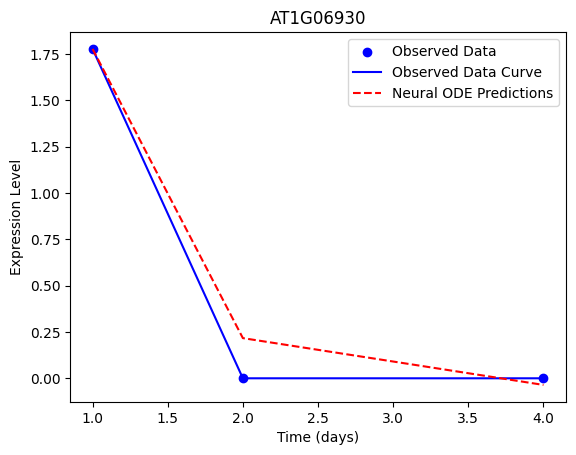

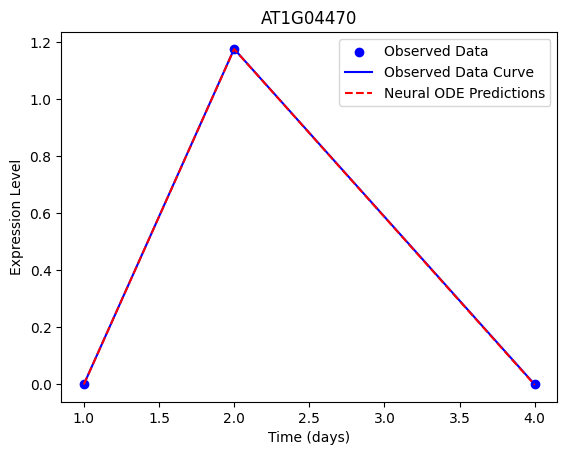

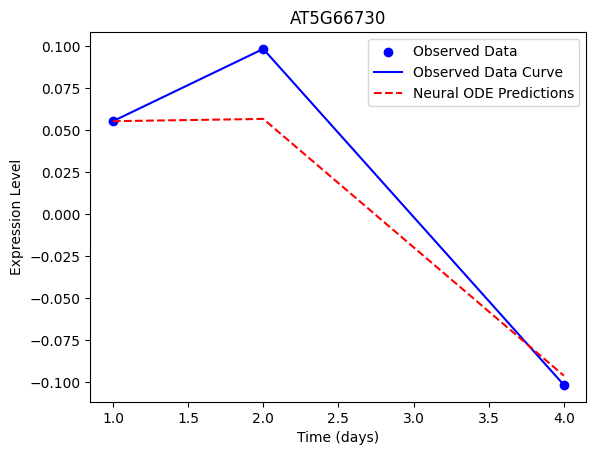


Learned ODE Equations:
dAT5G40100/dt = 0.1591 * tanh(-0.3148·t + -0.5889·t + 0.3987·t + 0.3112·t + 0.2756·t + -0.6294·t + 0.6186·t + -0.3345·t + 0.4698·t + -0.3043·t + 0.2520·t + 0.5392·t + 0.3014·t + -0.0272·t + 0.3924·t + -0.3475·t + 0.3379) + 0.0420

dAT1G06930/dt = -0.9991 * tanh(-1.6102·t + 3.1986·t + 2.6705·t + 1.0606·t + 0.7737·t + 0.0999·t + 0.2629·t + 0.2525·t + -1.5795·t + -0.7045·t + 0.2045·t + 0.2170·t + 0.3227·t + -0.2709·t + 1.6805·t + -1.0116·t + 3.7969) + 0.2140

dAT1G04470/dt = -0.1864 * tanh(1.5319·t + 0.2496·t + -1.4900·t + 1.8836·t + 1.1401·t + -0.4629·t + -0.2600·t + 2.5484·t + -0.1831·t + 1.8259·t + 0.9859·t + -1.6814·t + 0.6368·t + 0.3062·t + 0.3571·t + 0.2622·t + 1.6631) + -0.3534

dAT5G66730/dt = 0.1890 * tanh(-0.2906·t + 0.8977·t + 0.3568·t + 0.0511·t + 0.7729·t + 0.6719·t + 0.0623·t + 0.1770·t + -0.2277·t + -0.6943·t + -0.7312·t + -0.4517·t + 0.2412·t + 0.5427·t + 0.2344·t + 0.8043·t + -0.0920) + -0.0781



In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data (row-wise)
time_points = np.array([1.0, 2.0, 4.0])  # Days 1, 2, 4
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors (each row is a separate time series)
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)  # Enable gradients
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (4, 3)

class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a simple network for a single gene's dynamics
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time (scalar), Output: hidden state
            nn.Tanh(),
            nn.Linear(16, 1)    # Output: derivative of the gene's expression
        )

    def forward(self, t, y):
        # y: (batch_size, 1) = current gene expression
        # t: scalar
        t_tensor = torch.ones_like(y) * t  # Shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)  # Compute derivative
        return dy_dt

# Initialize one ODE model per gene
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_loss = 0.0
    for i in range(n_genes):
        # Extract data for the i-th gene
        y_true = gene_data[i].unsqueeze(-1)  # Shape: (3, 1)

        # Initial condition (expression at t=1d)
        y0 = y_true[0].unsqueeze(0)  # Shape: (1, 1)

        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # Shape: (3,)

        # Data loss (MSE between predictions and observed data)
        data_loss = torch.mean((preds - y_true.squeeze()) ** 2)

        # Physics loss (ODE consistency)
        # Compute dy/dt from the predictions using autograd
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Compute dy/dt from the ODE function
        dy_dt_ode = torch.stack([ode_models[i](t, p.unsqueeze(0)) for t, p in zip(time_points, preds)]).squeeze()

        # Physics loss (MSE between predicted and ODE-computed derivatives)
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        # Total loss
        total_loss += data_loss + lambda_physics * physics_loss

    return total_loss / n_genes  # Average loss across genes

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 400

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Generate predictions and plot results
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Initial condition (t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)

        # Solve the ODE
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Data Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

# Print learned ODE equations
print("\nLearned ODE Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    W1 = model.net[0].weight.detach().numpy().flatten()  # Input layer weights
    b1 = model.net[0].bias.detach().numpy().flatten()    # Input layer bias
    W2 = model.net[2].weight.detach().numpy().flatten()  # Output layer weights
    b2 = model.net[2].bias.detach().numpy().flatten()    # Output layer bias

    # ODE equation: dy/dt = W2 * tanh(W1 * t + b1) + b2
    equation = f"d{gene_id}/dt = "
    equation += f"{W2[0]:.4f} * tanh("
    equation += " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print(equation + "\n")